In [31]:
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
import keras.backend as kb
import tensorflow as tf

# Helper Functions

## 1. LogLogPlotter

In [63]:
from scipy import stats
import matplotlib.pyplot as plt

'''
Function that takes in two dataframe columns and plots a log-log graph
Follows standardised formatting
@input recorded: dataframe column of recorded data
@input predicted: dataframe column of the predicted value
@input xmin: lower bound of graph's x axis
@input xmax: upper bound of graph's x axis
@input ymin: lower bound of graph's y axis
@input ymax: upper bound of graph's y axis
@input xTitle: title for x axis
@input yTitle: title for y axis
@output log log graph of the preducted values against recorded values
'''

def logLogPlotter(recorded, predicted, xmin, xmax, ymin, ymax, xTitle, yTitle, units):
    x = recorded
    y = predicted

    coefficients = np.polyfit(np.log(x), np.log(y), 1)
    line_function = np.poly1d(coefficients)

    # Create a range for predicted values for the fit line
    x_vals = np.linspace(min(x), max(y), 400)
    y_vals = np.exp(line_function(np.log(x_vals)))

    #calculate similarity measures
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    #best fit line and y = x line
    plt.scatter(x, y, c='red', marker='x')
    plt.plot(x_vals, y_vals, color='red', label=f'Fit: y = {coefficients[0]:.2f}x + {coefficients[1]:.2f}')
    plt.axline((0, 0), (1,1),color='black',linestyle='--', label=f'y=x, R^2 = {r_value ** 2}',)

    #visuals
    font_family = 'Times New Roman'
    title_font_size=17
    label_font_size=15
    legend_tick_font_size=12

    plt.title(f'Predicted {yTitle} against Recorded {xTitle}', fontsize=title_font_size, fontfamily=font_family)
    plt.xlabel(f'Recorded {xTitle} ({units})', fontsize=label_font_size, fontfamily=font_family)
    plt.ylabel(f'Predicted {yTitle} ({units})', fontsize=label_font_size, fontfamily=font_family)

    plt.legend(fontsize = legend_tick_font_size)
    plt.loglog()
    plt.xlim(xmax=xmax, xmin=xmin)
    plt.ylim(ymax=ymax, ymin=ymin)

    plt.show()

# Data

In [33]:
data = pd.read_csv('../data/task1.1data.csv')
data[:5]

,air_temp,load_resistance,i_d,output_voltage,power_output
0,-10.0,350.0,4.464,18.9,80.3
1,-10.0,650.0,4.464,23.5,124.6
2,-10.0,950.0,4.464,24.8,138.6
3,-10.0,1250.0,4.464,25.6,146.9
4,10.0,350.0,4.464,19.2,83.1


## (a)

### Determining data median

In [34]:
median = data.median()
median

air_temp            10.000
load_resistance    800.000
i_d                  6.696
output_voltage      26.450
power_output       100.100
dtype: float64

### Normalising by median

In [35]:
norm_data = data.divide(median)
norm_data[:5]

,air_temp,load_resistance,i_d,output_voltage,power_output
0,-1.0,0.4375,0.666667,0.714556,0.802198
1,-1.0,0.8125,0.666667,0.888469,1.244755
2,-1.0,1.1875,0.666667,0.937618,1.384615
3,-1.0,1.5625,0.666667,0.967864,1.467532
4,1.0,0.4375,0.666667,0.725898,0.830170


In [36]:
mean_values = norm_data.mean()
mean_values

air_temp           1.000000
load_resistance    1.000000
i_d                1.000000
output_voltage     0.985297
power_output       1.088217
dtype: float64

In [37]:
air_temp_mean = mean_values[0]
load_resistance_mean = mean_values[1]
i_d_mean = mean_values[2]
output_voltage_mean = mean_values[3]
power_output_mean = mean_values[4]

## (b)

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X = norm_data[['air_temp', 'load_resistance', 'i_d']]
y = norm_data[['output_voltage', 'power_output']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)


## (c) 

In [40]:
'''>>>>> start CodeP3.1.2F23
    V.P. Carey ME249, Fall 2023

Intro to Neural Network Modeling 
Keras model for PV power system'''

#import useful packages
import keras
import pandas as pd
from keras.models import Sequential
import numpy as np
import keras.backend as kb
import tensorflow as tf
#the follwoing 2 lines are only needed for Mac OS machines
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# define meadian values of input variables - add your values here
Tamed = air_temp_mean  #make sure Tamed does not = 0
IDmed = i_d_mean
RLmed = load_resistance_mean

#Part 1 input data: Air temp (degC), ID (W/sqm), load resistance (ohms)
xdata = X_train
xarray= np.array(xdata)
# print (xdata)
# print (xarray)

# define meadian values of output variables - add your values here
VLmed = output_voltage_mean
Wdmed = power_output_mean

#create output data array
ydata = y_train
yarray= np.array(ydata)
# print (ydata)
# print (yarray)

In [41]:
# define neural network model

#As seen below, we have created four dense layers. 
#A dense layer is a layer in neural network that’s fully connected. 
#In other words, all the neurons in one layer are connected to all other neurons in the next layer.
#In the first layer, we need to provide the input shape, which is 1 in our case. 
#The activation function we have chosen is elu, which stands for exponential linear unit. .

from keras import backend as K
#initialize weights with values between -0.2 and 0.5
initializer = keras.initializers.RandomUniform(minval= -0.5, maxval=0.5)

model = keras.Sequential([
    keras.layers.Dense(6, activation=K.elu, input_shape=[3],  kernel_initializer=initializer),
    keras.layers.Dense(9, activation=K.elu,  kernel_initializer=initializer),
    keras.layers.Dense(13, activation=K.elu, kernel_initializer=initializer),
    keras.layers.Dense(7, activation=K.elu, kernel_initializer=initializer),
    keras.layers.Dense(2,  kernel_initializer=initializer)
  ])


In [42]:
#We’re using RMSprop as our optimizer here. RMSprop stands for Root Mean Square Propagation. 
#It’s one of the most popular gradient descent optimization algorithms for deep learning networks. 
#RMSprop is an optimizer that’s reliable and fast.
#We’re compiling the mode using the model.compile function. The loss function used here 
#is mean squared error. After the compilation of the model, we’ll use the fit method with ~500 epochs.
#Number of epochs can be varied.

#from tf.keras import optimizers
rms = keras.optimizers.RMSprop(0.010)
model.compile(loss='mean_absolute_error',optimizer=rms)


## (d)

In [43]:
#After the compilation of the model, we’ll use the fit method with 500 epochs.
#I started with epochs value of 100 and then tested the model after training. 
#The prediction was not that good. Then I modified the number of epochs to 200 and tested the model again. 
#Accuracy had improved slightly, but figured I’d give it one more try. Finally, at 500 epochs 
#I found acceptable prediction accuracy.

#The fit method takes three parameters; namely, x, y, and number of epochs. 
#During model training, if all the batches of data are seen by the model once, 
#we say that one epoch has been completed.

# Add an early stopping callback
es = keras.callbacks.EarlyStopping(
    monitor='loss', 
    mode='min', 
    patience = 80, 
    restore_best_weights = True, 
    verbose=1)
# Add a checkpoint where loss is minimum, and save that model
mc = keras.callbacks.ModelCheckpoint('best_model.SB', monitor='loss', 
                     mode='min',  verbose=1, save_best_only=True)

historyData = model.fit(xarray,yarray,epochs=800,callbacks=[es])

loss_hist = historyData.history['loss']
#The above line will return a dictionary, access it's info like this:
best_epoch = np.argmin(historyData.history['loss']) + 1
print ('best epoch = ', best_epoch)

print('smallest loss =', np.min(loss_hist))

model.save('best_model.h5')

Epoch 1/800
24/24 [==============================] - 1s 24ms/step - loss: 1.4019
Epoch 2/800
24/24 [==============================] - 0s 85us/step - loss: 0.9185
Epoch 3/800
24/24 [==============================] - 0s 113us/step - loss: 0.6607
Epoch 4/800
24/24 [==============================] - 0s 494us/step - loss: 0.4365
Epoch 5/800
24/24 [==============================] - 0s 98us/step - loss: 0.2259
Epoch 6/800
24/24 [==============================] - 0s 93us/step - loss: 0.2974
Epoch 7/800
24/24 [==============================] - 0s 74us/step - loss: 0.2270
Epoch 8/800
24/24 [==============================] - 0s 98us/step - loss: 0.2534
Epoch 9/800
24/24 [==============================] - 0s 105us/step - loss: 0.1771
Epoch 10/800
24/24 [==============================] - 0s 122us/step - loss: 0.2488
Epoch 11/800
24/24 [==============================] - 0s 86us/step - loss: 0.1580
Epoch 12/800
24/24 [==============================] - 0s 89us/step - loss: 0.1698
Epoch 13/800
24/24 [=

### This line doesn't work for me - shawn

In [14]:


# This line of code can be used to reconstruct the saved model.

# recon_model = keras.models.load_model("best_model.h5")

# the name of the model is now "recon_model". You can then use this model to do predictions for comparisons.
# See the previous project for code to do the comparisons.








## (e)

In [44]:
y_predictions = model.predict(X_train[['air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df


,output_voltage,power_output
0,0.783173,0.891796
1,0.686604,1.032346
2,1.030838,0.825389
3,1.031730,1.145860
4,1.053702,1.369855
5,0.909546,1.477949
6,1.052611,2.056277
7,0.897995,1.218300
8,0.956372,0.663032
9,0.950326,1.429811


In [45]:
y_recorded_df = y_train[['output_voltage', 'power_output']]
y_recorded_df


,output_voltage,power_output
0,0.714556,0.802198
4,0.725898,0.830170
29,1.024575,0.826174
15,0.998110,1.044955
19,1.069943,1.194805
5,0.945180,1.403596
11,1.096408,1.892108
1,0.888469,1.244755
24,0.888469,0.621379
2,0.937618,1.384615


### (i) Mean Absolute Error

In [46]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_recorded_df['power_output'], y_predictions_df['power_output'])
print(f'MAE: {mae}')

MAE: 0.08991956452538558


### (ii) log-log plot

#### Training set: Predicted vs Recorded


/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


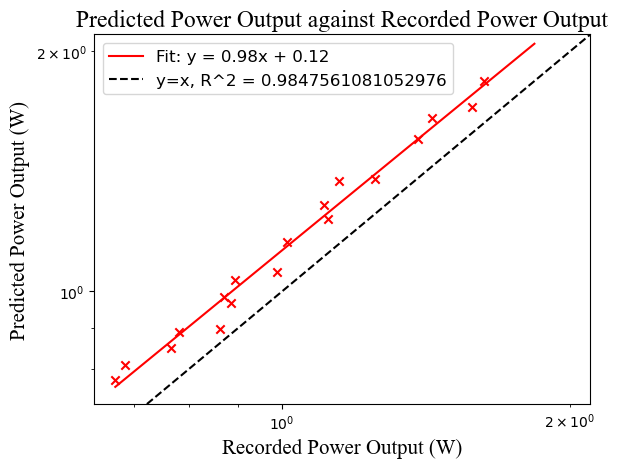

In [64]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 2.1, -0.5, 2.1, 'Power Output', 'Power Output', 'W')

## (f)

#### Validation Set: Predicted vs Recorded

In [48]:
y_predictions = model.predict(X_test[['air_temp', 'load_resistance', 'i_d']])
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df

,output_voltage,power_output
0,1.128590,1.177267
1,0.969410,0.857034
2,1.041303,0.825915
3,1.071719,0.913595
4,0.868328,0.771040
5,1.087755,0.998699
6,1.004434,1.152094
7,0.889143,0.694607
8,0.706708,1.163275
9,0.995825,0.999553


In [49]:
y_recorded_df = y_test[['output_voltage', 'power_output']]
y_recorded_df

,output_voltage,power_output
35,1.156900,1.050949
13,0.937618,0.921079
26,0.994329,0.775225
30,1.062382,0.886114
16,0.892250,0.836164
31,1.085066,0.927073
21,1.062382,1.180819
12,0.846881,0.751249
8,0.733459,0.846154
17,1.001890,1.047952


### (i) Mean Absolute Error

In [50]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_recorded_df['power_output'], y_predictions_df['power_output'])
print(f'MAE: {mae}')

MAE: 0.08032387066316178


### (ii) log-log plot

#### Validation set: Predicted vs Recorded


# @TODO: CHECK THIS

/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


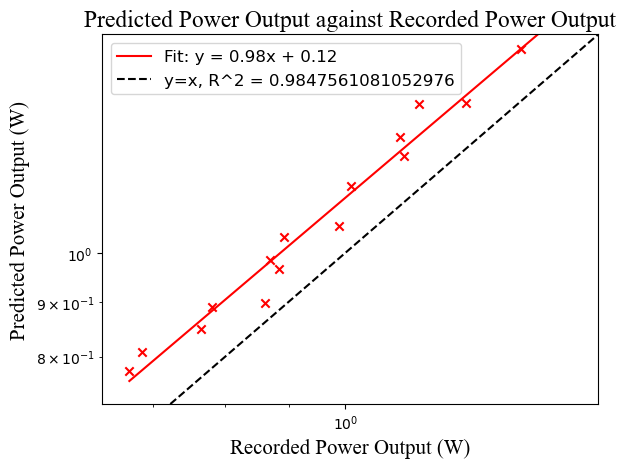

In [65]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 1.6, -0.5, 1.6, 'Power Output', 'Power Output', 'W')

# (g)

### Import data for ID > 1300 W/m^2

In [52]:
data = pd.read_csv('../data/task1.2_g_data.csv')
data[:5]

,air_temp,load_resistance,i_d,output_voltage,power_output
0,-10.0,1550.0,4.464,26.1,152.8
1,-10.0,1850.0,4.464,26.5,172.7
2,10.0,1550.0,4.464,27.9,191.4
3,10.0,1850.0,4.464,28.3,198.0
4,30.0,1550.0,4.464,29.6,217.8


### Determining data median

In [53]:
median = data.median()
median

air_temp             10.000
load_resistance    1700.000
i_d                   6.696
output_voltage       28.950
power_output        138.000
dtype: float64

### Normalising by median

In [54]:
norm_data = data.divide(median)
norm_data[:5]

,air_temp,load_resistance,i_d,output_voltage,power_output
0,-1.0,0.911765,0.666667,0.901554,1.107246
1,-1.0,1.088235,0.666667,0.915371,1.251449
2,1.0,0.911765,0.666667,0.963731,1.386957
3,1.0,1.088235,0.666667,0.977547,1.434783
4,3.0,0.911765,0.666667,1.022453,1.578261


In [55]:
X_data = norm_data[['air_temp', 'load_resistance', 'i_d']]
y_data = norm_data[['output_voltage', 'power_output']]

### Predicted values of new dataset using trained model

In [56]:
y_predictions = model.predict(X_data)
y_predictions_df = pd.DataFrame(y_predictions, columns=['output_voltage', 'power_output'])
y_predictions_df

,output_voltage,power_output
0,0.915477,1.283243
1,0.939743,1.381956
2,0.940513,1.551056
3,0.976801,1.651929
4,0.942491,1.703696
5,0.990780,1.835533
6,0.984876,0.897316
7,1.006109,0.967092
8,1.017354,1.059023
9,1.039825,1.154021


In [57]:
y_recorded_df = y_data
y_recorded_df

,output_voltage,power_output
0,0.901554,1.107246
1,0.915371,1.251449
2,0.963731,1.386957
3,0.977547,1.434783
4,1.022453,1.578261
5,1.039724,1.626087
6,0.929188,0.860870
7,0.939551,0.884783
8,0.994819,0.988406
9,1.005181,1.011594


### (i) Mean Absolute Error

In [58]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_recorded_df['power_output'], y_predictions_df['power_output'])
print(f'MAE: {mae}')

MAE: 0.13208913197455968


### (ii) log-log plot

#### Predicted vs Recorded


/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/shawnchan/opt/anaconda3/envs/MECENG249/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


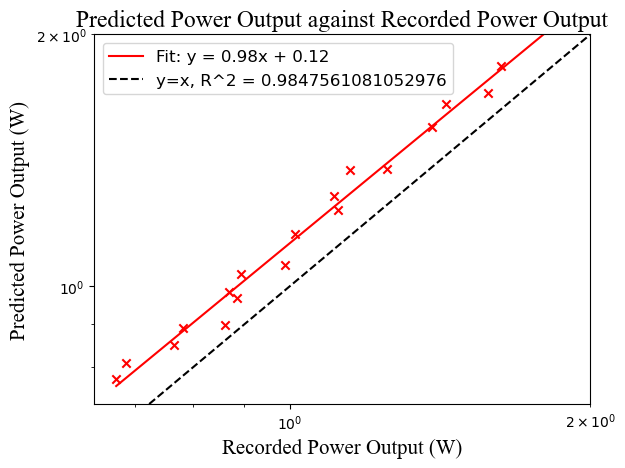

In [67]:
logLogPlotter(y_recorded_df['power_output'], y_predictions_df['power_output'], -0.5, 2, -0.5, 2, 'Power Output', 'Power Output', 'W')

# (h)

## @TODO: Fix plot

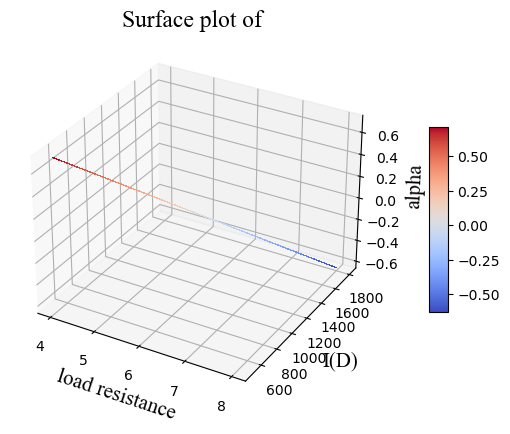

In [28]:
test = []
numeriter=100
outpt1=np.zeros((numeriter,numeriter))
outpt2=np.zeros((numeriter,numeriter))

#normalized
RL=np.linspace(4,8,numeriter)
RLnorm=RL/load_resistance_mean
ID=np.linspace(500,1800,numeriter)
IDnorm=ID/i_d_mean

for i in range(len(RL)):
    for j in range(len(ID)):
        test = [[RLnorm[i] , 20 , IDnorm[j] ]]
        testarray = np.array(test)
        a= model.predict(testarray)
        outpt1[i,j] = a[0,0]
        outpt2[i,j] = a[0,1]
  
# display(a)
outpt1=outpt1*output_voltage_mean #check
outpt2=outpt2*power_output_mean
# display(outpt1)
font_family = 'Times New Roman'
title_font_size=17
label_font_size=15
legend_tick_font_size=12
#SETTING UP PLOT

#Surface Plot
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(RL, ID, outpt1,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.1)
plt.xlabel("load resistance", fontsize=label_font_size, fontfamily=font_family)
plt.ylabel("I(D)", fontsize=label_font_size, fontfamily=font_family)
ax.set_zlabel('alpha', fontsize=label_font_size, fontfamily=font_family)
plt.title('Surface plot of ', fontsize=title_font_size, fontfamily=font_family)
plt.show()

# outpt1_df = pd.DataFrame(outpt1)
# display(outpt1_df)

# @TODO

# Comparison with previous model: